In [16]:
import pandas as pd
import sys
import os
import inspect
import joblib
import pickle
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

currentdir = %pwd
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)


from EDA.stratégie_nettoyage_donnees import nettoyage_df
from import_data_from_bdd import charger_donnees

In [5]:
df = charger_donnees(r"C:\Users\Utilisateur\Desktop\PCO\E1\code\bdd_sqlite_entrainement\db.db")

Le jeu de donnée a été chargé à partir de la base de données.


In [9]:
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,Other,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,Male,Other,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Other,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,Other,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,Other,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


# Diviser la bdd en base d'entraînement et de test

In [6]:
X = df.drop("treatment", axis=1)
y = df["treatment"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1028, 22)
(1028,)
(226, 22)
(226,)


# Preprocessing

## Analyse colonnes

In [13]:
df.dtypes

Age                           int64
Gender                       object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
dtype: object

In [14]:
df.columns

Index(['Age', 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [15]:
cat_columns = ['Gender', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

## ColumnTransformer

In [16]:
ct = ColumnTransformer(
    [("standardisation", StandardScaler(), ["Age"]),
    ("onehot", OneHotEncoder(), cat_columns)]
)

# Modèles

In [17]:
models = {
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
}

In [18]:
y_test = np.array(y_test)

In [24]:
dictionnary = {}

for model_name in models:
    pipeline = make_pipeline(ct, models[model_name])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label="Yes").round(3)
    recall = recall_score(y_test, y_pred, pos_label="Yes").round(3)
    f1 = f1_score(y_test, y_pred, pos_label="Yes").round(3)
    dictionnary[model_name] = {}
    dictionnary[model_name]["precision"] = precision
    dictionnary[model_name]["recall"] = recall
    dictionnary[model_name]["f1"] = f1

d:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\E1\nouveau_projet_perso\code\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [26]:
pd.DataFrame(dictionnary)

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
precision,0.84,0.796,0.769,0.811,0.808,0.802
recall,0.82,0.639,0.680,0.811,0.828,0.828
f1,0.83,0.709,0.722,0.811,0.818,0.815


La régression logistique obtient le meilleur score, le f1 score est la moyenne harmonique de la précision et de l'accuracy.
La précision mesure le taux de vrais positifs (vrais positifs sur positifs prédits).
Le recall mesure les vrais positifs sur les positifs réels (vrais positifs plus faux négatifs)

In [27]:
pipeline = make_pipeline(ct, LogisticRegression())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, pos_label="Yes")
print(list(pipeline.named_steps.keys())[1], f"f1 score is {f1}")

logisticregression f1 score is 0.8298755186721992


In [32]:
pickle.dump(pipeline, open("models/pipeline_logisticregression0.83f1.pkl", "wb"))

In [8]:
pipeline = pickle.load(open("models/pipeline_logisticregression0.83f1.pkl", "rb"))

In [13]:
X_test.iloc[[0]]

,Age,Gender,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,ids
2,32,Male,Other,No,Rarely,6-25,No,Yes,No,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,2


In [14]:
pipeline.predict(X_test.iloc[[0]])

array(['Yes'], dtype=object)

# Sauvegarde des résultats

In [35]:
# pd.DataFrame(dictionnary).to_excel("Résultats.xlsx")

In [17]:
y_test

2        No
182     Yes
935     Yes
317     Yes
918     Yes
       ... 
16      Yes
1106    Yes
1003     No
1206     No
329      No
Name: treatment, Length: 251, dtype: object

[[100  24]
 [ 16 111]]


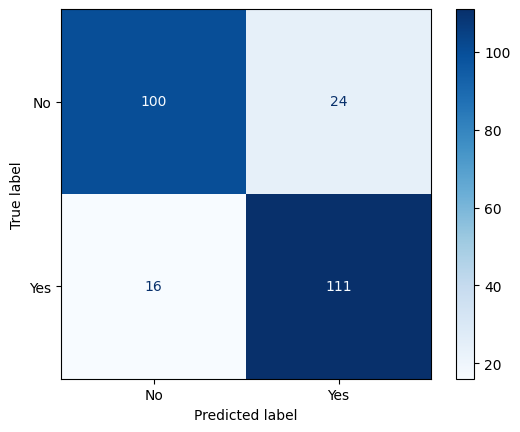

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )

print(disp.confusion_matrix)

plt.show()